#If training is slow try restarting the notebook and re-run the code

In [3]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-avnrndhl
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-avnrndhl
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=7325 sha256=93dfd4f07cb6d4755304c37134c9c02b16b3403f0f639e68aad35620831bf611
  Stored in directory: /tmp/pip-ephem-wheel-cache-mg43nk4s/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR


In [5]:
!pip install flashtorch
!pip install barbar

In [6]:
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools

In [11]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create new folder on your google drive like below:

In [12]:
os.chdir('/content/drive/MyDrive/Data1/flowers102/')

In [13]:
#This code will download the dataset
!wget https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip 'flower_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: flower_data/train/7/image_07232.jpg  
  inflating: flower_data/train/7/image_08101.jpg  
  inflating: flower_data/train/7/image_07226.jpg  
  inflating: flower_data/train/7/image_07227.jpg  
  inflating: flower_data/train/7/image_08100.jpg  
  inflating: flower_data/train/7/image_07233.jpg  
   creating: flower_data/train/29/
  inflating: flower_data/train/29/image_04152.jpg  
  inflating: flower_data/train/29/image_04147.jpg  
  inflating: flower_data/train/29/image_04153.jpg  
  inflating: flower_data/train/29/image_04151.jpg  
  inflating: flower_data/train/29/image_04150.jpg  
  inflating: flower_data/train/29/image_04144.jpg  
  inflating: flower_data/train/29/image_04140.jpg  
  inflating: flower_data/train/29/image_04154.jpg  
  inflating: flower_data/train/29/image_04155.jpg  
  inflating: flower_data/train/29/image_04141.jpg  
  inflating: flower_data/train/29/image_04157.jpg  
  inflating: flower_data/train/29/im

In [15]:
dataset_labels = pd.read_csv('Oxford-102_Flower_dataset_labels.txt',header=None)[0]

In [16]:
data_dir = '/content/drive/My Drive/Data1/flowers102/flower_data/'

In [17]:
mean = np.array([0.485, 0.456, 0.406]) #parameters for applying iage transformation to the code
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #Data Augmentation 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [18]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']} #accepts images in both train and valid folders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'valid']} #creates a batch of datasets for training
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
dataset_sizes

{'train': 6552, 'valid': 818}

In [20]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

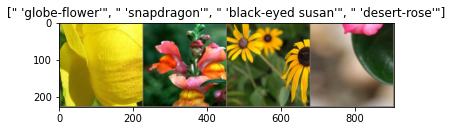

In [21]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:7]
classes = classes[:7] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[int(class_names[x])-1] for x in classes])  #samples a batch of flowers from the train dataset and shows some sample species

In [22]:
from barbar import Bar

In [23]:
def train_model(model, num_epochs=25): #defining funtion to fine tune our model to classify the species of flowers

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() 
        running_corrects = 0
        for inputs, labels in Bar(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data) #stores prediction accuracy after each training epc

            loss = criterion(outputs, labels) #loss function
            loss.backward() #propagates the loss down the network
            optimizer.step() #uses SGD optimizer to optimize gradient descent

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train'])) #prints prediction accuracy after each training epoch
        
        scheduler.step() #tunes the gradient descent optimizer after each training epoc
    
        ###Val
        model.eval()  #evaluates the model after each training on the test dataset. required to remove the gradients and parameters not to be affected during validation
        running_corrects = 0
        for inputs, labels in Bar(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [24]:
model = models.resnet18(pretrained=True) #using pre trained resnet model, which will be fine tuned to classify different flower specie
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [25]:
model = train_model(model, num_epochs=3) #training model for 3 epochs

Epoch:  1 / 3
6552/6552: [===============================>] - ETA 0.9s
Train  Acc: 0.39
818/818: [===============================>] - ETA 0.7s
Valid  Acc: 0.79
#######################
Epoch:  2 / 3
6552/6552: [===============================>] - ETA 0.6s
Train  Acc: 0.76
818/818: [===============================>] - ETA 0.6s
Valid  Acc: 0.92
#######################
Epoch:  3 / 3
6552/6552: [===============================>] - ETA 0.6s
Train  Acc: 0.85
818/818: [===============================>] - ETA 0.6s
Valid  Acc: 0.96
#######################


In [27]:
def visualize_model(model, num_images=16): #function to visualize the trained model
    model.eval()
    index = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[int(class_names[preds[j]])-1] + '     class: ' + dataset_labels[int(class_names[labels[j]])-1]
            imshow(inputs.cpu().data[j],title1)

            if index == num_images:
                return

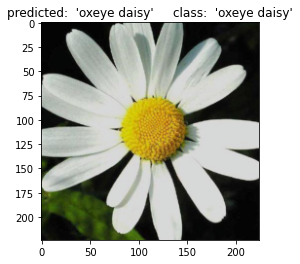

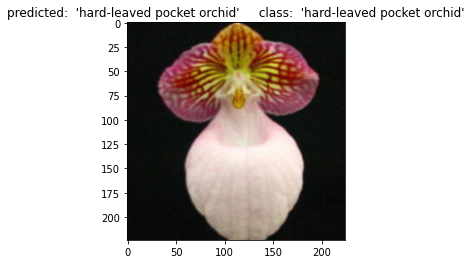

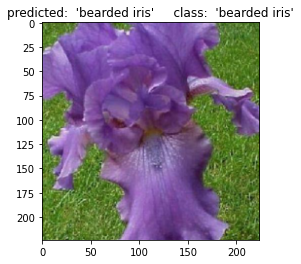

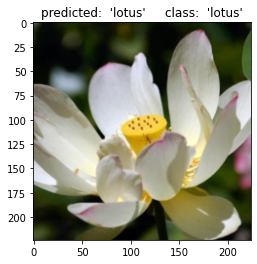

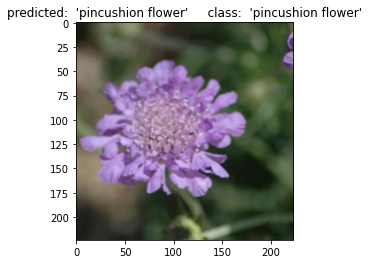

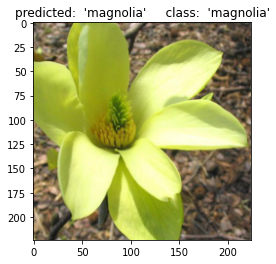

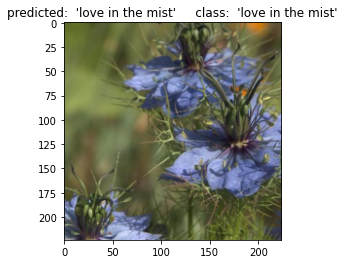

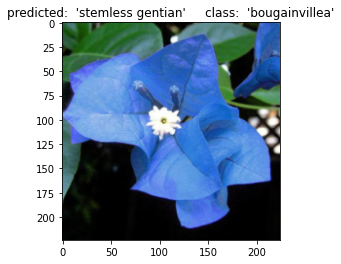

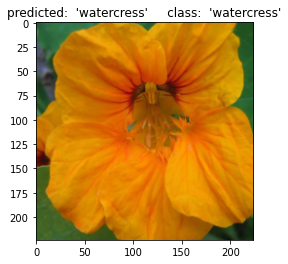

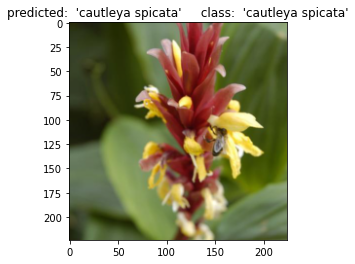

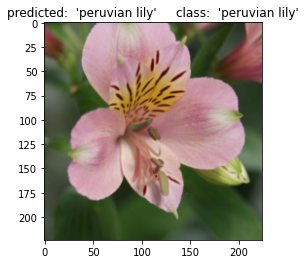

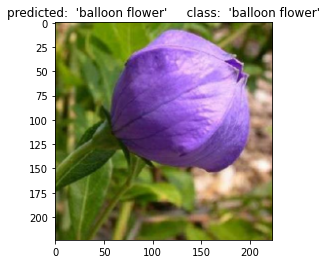

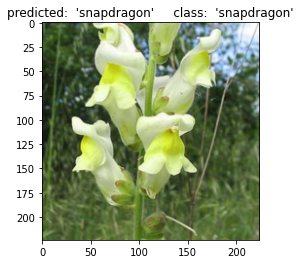

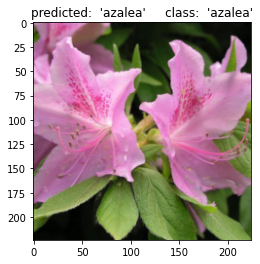

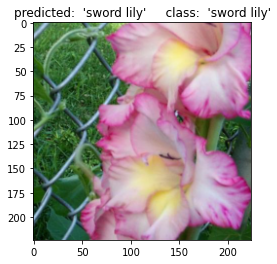

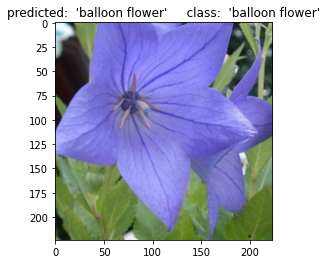

In [28]:
visualize_model(model) #Shows the accuracay of predcition on some sample images in the dataset, default sample size is 16

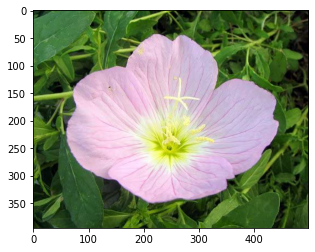

In [29]:
image = io.imread('https://images-na.ssl-images-amazon.com/images/I/51dZp-%2B4W9L._AC_.jpg') #selecting a random flower from the internet and testing how well it does
plt.imshow(image);

In [30]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [ ]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]

In [ ]:
print('predicted: ' + dataset_labels[int(class_names[preds])-1])

predicted:  'pink primrose'


In [ ]:
#Testing the model on paintings of flowers

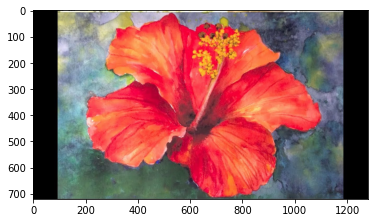

In [32]:
image = io.imread('https://i.ytimg.com/vi/RUb_RicoDsI/maxresdefault.jpg')
plt.imshow(image)

In [33]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [34]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]
print('predicted: ' + dataset_labels[int(class_names[preds])-1])

predicted:  'watercress'


In [35]:
#a remarkable funny fail of the classifier. Although it achieved 95%accuracy in predicting real world images, 
#but cannot understand paintings